# Project Description: "Needs to be completed"

## How to load and format data was taking from: https://colab.research.google.com/github/trekhleb/machine-learning-experiments/blob/master/experiments/rock_paper_scissors_cnn/rock_paper_scissors_cnn.ipynb#scrollTo=DJ8jGFnTLt8t

### Un-comment and run if your environment is missing tensorflow datasets package.

In [55]:
#! pip install tensorflow_datasets

In [56]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [57]:
# Load the Rock Paper Scissors dataset
(train_dataset,test_dataset)  , dataset_info = tfds.load('rock_paper_scissors', data_dir='tmp', with_info=True,as_supervised=True, split=[tfds.Split.TRAIN, tfds.Split.TEST])

In [58]:
dataset_info

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    full_name='rock_paper_scissors/3.0.0',
    description="""
    Images of hands playing rock, paper, scissor game.
    """,
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    data_path='tmp/rock_paper_scissors/3.0.0',
    file_format=tfrecord,
    download_size=219.53 MiB,
    dataset_size=219.23 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=372, num_shards=1>,
        'train': <SplitInfo num_examples=2520, num_shards=2>,
    },
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
)

In [59]:
NUM_TRAIN_EXAMPLES = dataset_info.splits['train'].num_examples
NUM_TEST_EXAMPLES = dataset_info.splits['test'].num_examples
NUM_CLASSES = dataset_info.features['label'].num_classes

print('Number of TRAIN examples:', NUM_TRAIN_EXAMPLES)
print('Number of TEST examples:', NUM_TEST_EXAMPLES)
print('Number of label classes:', NUM_CLASSES)

Number of TRAIN examples: 2520
Number of TEST examples: 372
Number of label classes: 3


In [60]:
INPUT_IMG_SIZE_ORIGINAL = dataset_info.features['image'].shape[0]
INPUT_IMG_SHAPE_ORIGINAL = dataset_info.features['image'].shape

INPUT_IMG_SIZE_REDUCED = INPUT_IMG_SIZE_ORIGINAL // 2
INPUT_IMG_SHAPE_REDUCED = (
    INPUT_IMG_SIZE_REDUCED,
    INPUT_IMG_SIZE_REDUCED,
    INPUT_IMG_SHAPE_ORIGINAL[2]
)
INPUT_IMG_SIZE = INPUT_IMG_SIZE_REDUCED
INPUT_IMG_SHAPE = INPUT_IMG_SHAPE_REDUCED

print (INPUT_IMG_SHAPE)

(150, 150, 3)


In [61]:
get_label_name = dataset_info.features['label'].int2str
def preview_dataset(dataset):
    plt.figure(figsize=(12, 12))
    plot_index = 0
    for features in dataset.take(12):
        (image, label) = features
        plot_index += 1
        plt.subplot(3, 4, plot_index)
        # plt.axis('Off')
        label = get_label_name(label.numpy())
        plt.title('Label: %s' % label)
        plt.imshow(image.numpy())

### Pre-Process the dataset

In [62]:
def preprocess_image(image , label):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image , [INPUT_IMG_SIZE, INPUT_IMG_SIZE])
    return image, label


train_dataset = train_dataset.map(preprocess_image)
test_dataset= test_dataset.map(preprocess_image)

In [63]:
(first_image, first_lable) = list(train_dataset)[0]
print('Label:', first_lable.numpy(), '\n')
print('Image shape:', first_image.numpy().shape, '\n')
print(first_image.numpy())

Label: 2 

Image shape: (150, 150, 3) 

[[[0.995098   0.995098   0.995098  ]
  [0.995098   0.995098   0.995098  ]
  [0.995098   0.995098   0.995098  ]
  ...
  [0.9852941  0.9852941  0.9852941 ]
  [0.9843137  0.9843137  0.9843137 ]
  [0.98039216 0.98039216 0.98039216]]

 [[0.99607843 0.99607843 0.99607843]
  [0.995098   0.995098   0.995098  ]
  [0.995098   0.995098   0.995098  ]
  ...
  [0.98333335 0.98333335 0.98333335]
  [0.9813726  0.9813726  0.9813726 ]
  [0.98333335 0.98333335 0.98333335]]

 [[0.99607843 0.99607843 0.99607843]
  [0.9941176  0.9941176  0.9941176 ]
  [0.9941176  0.9941176  0.9941176 ]
  ...
  [0.9852941  0.9852941  0.9852941 ]
  [0.9852941  0.9852941  0.9852941 ]
  [0.9813726  0.9813726  0.9813726 ]]

 ...

 [[0.9862745  0.9862745  0.9862745 ]
  [0.98725486 0.98725486 0.98725486]
  [0.9882353  0.9882353  0.9882353 ]
  ...
  [0.9705882  0.9705882  0.9705882 ]
  [0.97352946 0.97352946 0.97352946]
  [0.9754902  0.9754902  0.9754902 ]]

 [[0.9882353  0.9882353  0.9882353

### Data Exploration:

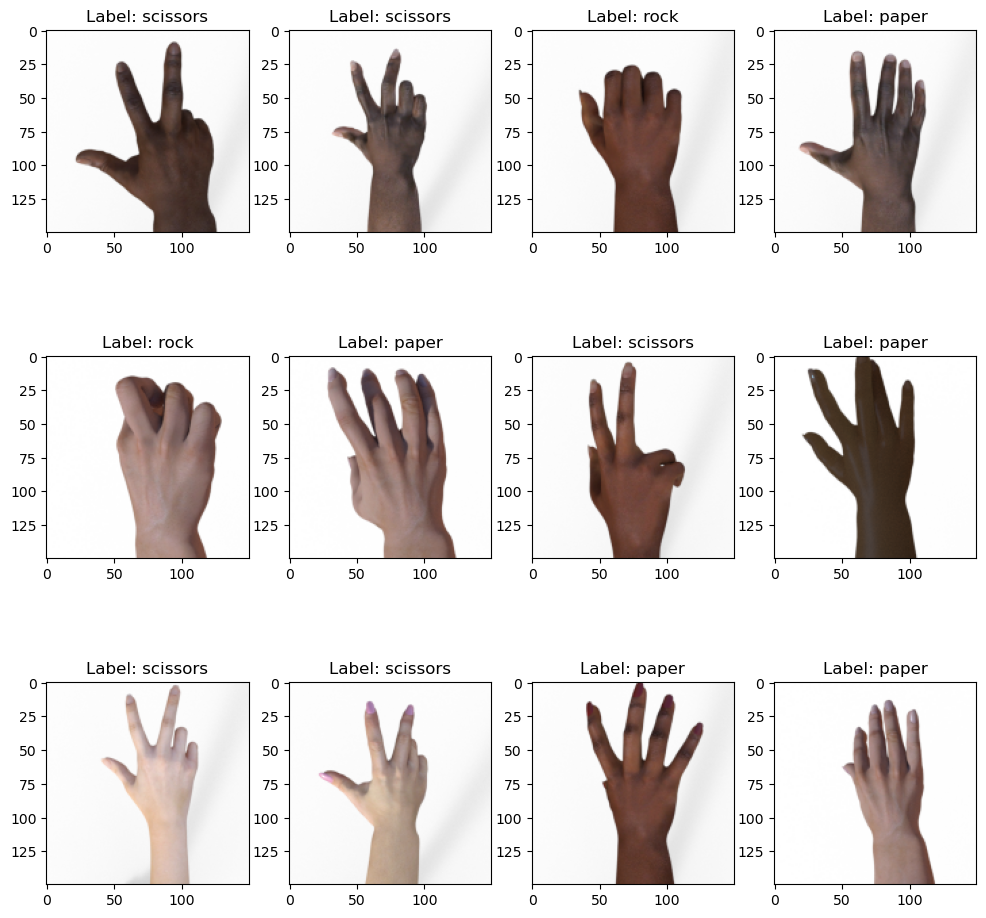

In [64]:
preview_dataset(train_dataset)

# Data Augmentation
This include rotating images, flipping images, changing color, and zoom. Augmentations taken from: https://www.wouterbulten.nl/posts/data-augmentation-using-tensorflow-data-dataset/

In [65]:
def flip(x: tf.Tensor) -> tf.Tensor:
    """Flip augmentation

    Args:
        x: Image to flip

    Returns:
        Augmented image
    """
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)

    return x



def color(x: tf.Tensor) -> tf.Tensor:
    """Color augmentation

    Args:
        x: Image

    Returns:
        Augmented image
    """
    x = tf.image.random_hue(x, 0.08)
    x = tf.image.random_saturation(x, 0.6, 1.6)
    x = tf.image.random_brightness(x, 0.09)
    x = tf.image.random_contrast(x, 0.1, 1.3)
    return x

def rotate(x: tf.Tensor) -> tf.Tensor:
    """Rotation augmentation

    Args:
        x: Image

    Returns:
        Augmented image
    """

    return tf.image.rot90(x, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))


def zoom(x: tf.Tensor) -> tf.Tensor:
    """Zoom augmentation

    Args:
        x: Image

    Returns:
        Augmented image
    """

    # Generate 20 crop settings, ranging from a 1% to 20% crop.
    scales = list(np.arange(0.8, 1.0, 0.01))
    boxes = np.zeros((len(scales), 4))

    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]

    def random_crop(img):
        # Create different crops for an image
        crops = tf.image.crop_and_resize([img], boxes=boxes, box_indices=np.zeros(len(scales)), crop_size=(32, 32))
        # Return a random crop
        return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]


    choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)

    # Only apply cropping 50% of the time
    return tf.cond(choice < 0.5, lambda: x, lambda: random_crop(x))

def augment_data(image, label):
    image = flip(image)
    image = color(image)
    image = rotate(image)
    #image = zoom(image)
    return image, label


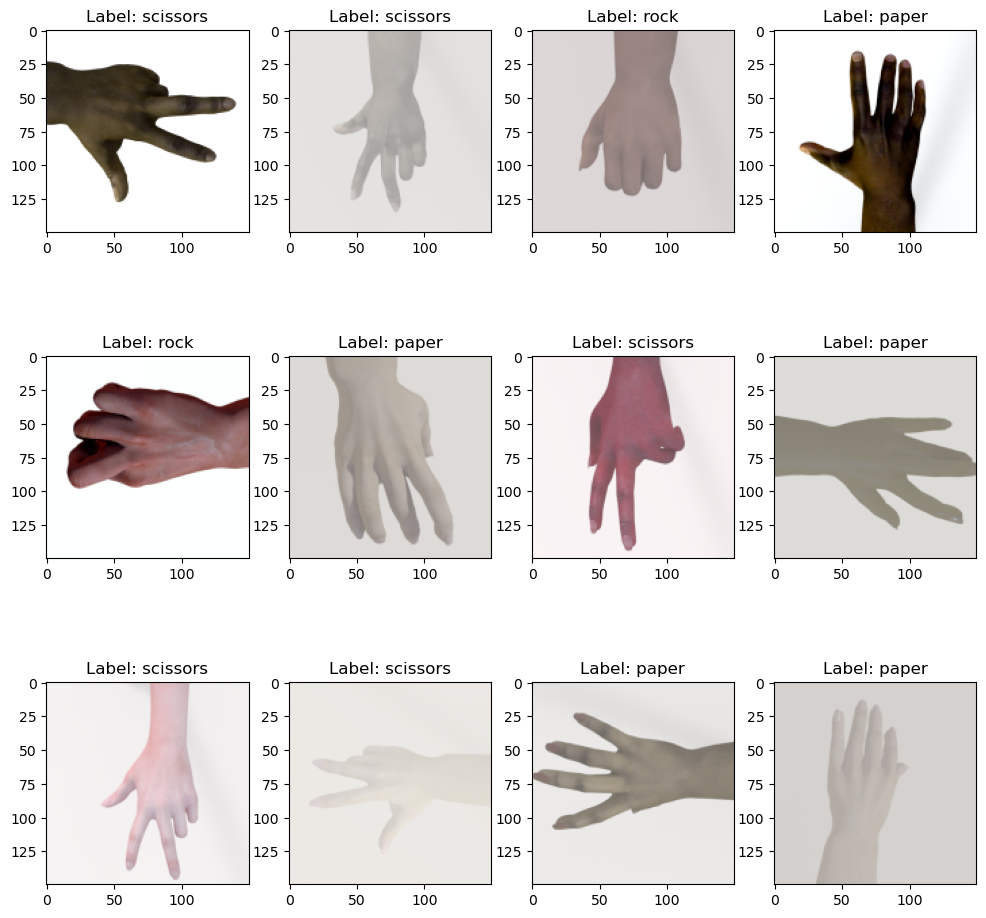

In [66]:
train_dataset_augmented = train_dataset.map(augment_data)
preview_dataset(train_dataset_augmented)

# Data Shuffling and Batching
in order to prevent the model learning from order or grouping of images, we will shuffle the training examples.

In [67]:
BATCH_SIZE = 32

train_dataset_augmented_shuffled = train_dataset_augmented.shuffle(
    buffer_size=1000
)

train_dataset_augmented_shuffled = train_dataset_augmented.batch(
    batch_size=BATCH_SIZE
)

# Prefetch will enable the input pipeline to asynchronously fetch batches while your model is training.
dataset_train_augmented_shuffled = train_dataset_augmented_shuffled.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE
)

test_dataset_shuffled = test_dataset.batch(BATCH_SIZE)

In [68]:
print(train_dataset_augmented_shuffled)
print(test_dataset_shuffled)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [69]:
# Define the CNN model

#1
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=INPUT_IMG_SHAPE),
    tf.keras.layers.MaxPooling2D((2, 2)),
#2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
#3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
#4
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [70]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 17, 17, 128)     

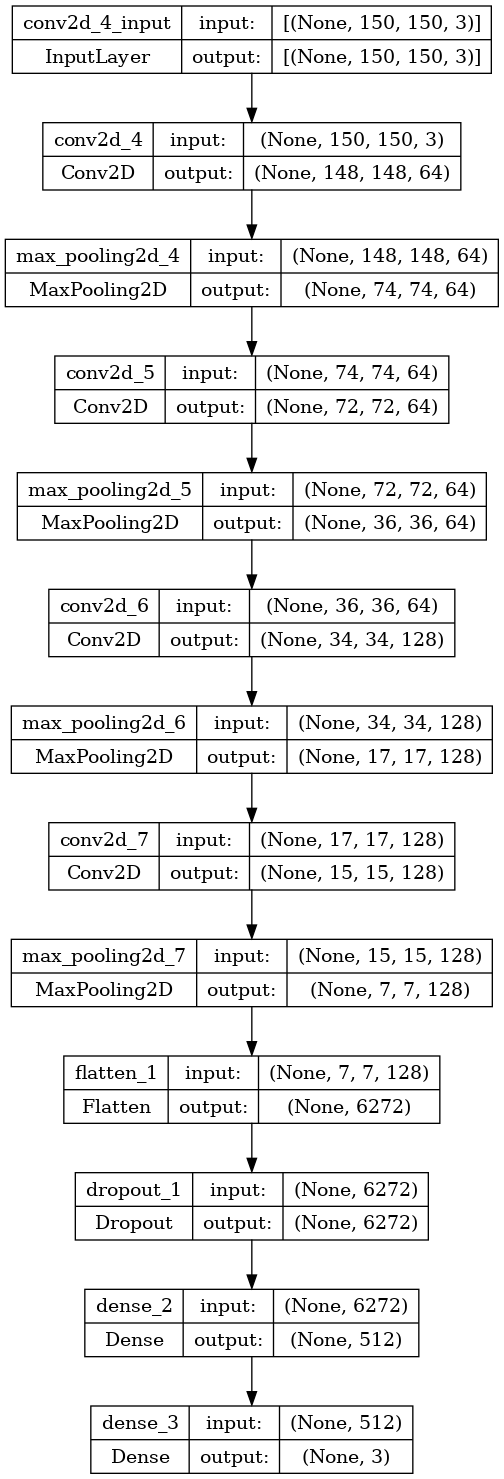

In [71]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

In [72]:
# we can also add learning rate to optimizer
# adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
rmsprop_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

# Compile cnn model
model.compile(optimizer= rmsprop_optimizer , loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [73]:

# Train cnn mmodel
model.fit(train_dataset_augmented_shuffled, epochs=40)

Epoch 1/40
79/79 [==============================] - 7s 61ms/step - loss: 1.1455 - accuracy: 0.3639
Epoch 2/40
79/79 [==============================] - 4s 49ms/step - loss: 0.9549 - accuracy: 0.5337
Epoch 3/40
79/79 [==============================] - 4s 55ms/step - loss: 0.6702 - accuracy: 0.7464
Epoch 4/40
79/79 [==============================] - 4s 53ms/step - loss: 0.3768 - accuracy: 0.8679
Epoch 5/40
79/79 [==============================] - 4s 53ms/step - loss: 0.2526 - accuracy: 0.9246
Epoch 6/40
79/79 [==============================] - 4s 50ms/step - loss: 0.1741 - accuracy: 0.9476
Epoch 7/40
79/79 [==============================] - 4s 51ms/step - loss: 0.1200 - accuracy: 0.9643
Epoch 8/40
79/79 [==============================] - 5s 57ms/step - loss: 0.1210 - accuracy: 0.9694
Epoch 9/40
79/79 [==============================] - 4s 51ms/step - loss: 0.1139 - accuracy: 0.9702
Epoch 10/40
79/79 [==============================] - 4s 51ms/step - loss: 0.1074 - accuracy: 0.9710
Epoch 11/

In [74]:
# Evaluate cnn model
model.evaluate(test_dataset_shuffled)

12/12 [==============================] - 1s 70ms/step - loss: 2.2137 - accuracy: 0.8952


[2.2137343883514404, 0.8951612710952759]

In [75]:
BATCH_SIZE = 32
steps_per_epoch = NUM_TRAIN_EXAMPLES // BATCH_SIZE
validation_steps = NUM_TEST_EXAMPLES // BATCH_SIZE

print('steps_per_epoch:', steps_per_epoch)
print('validation_steps:', validation_steps)

steps_per_epoch: 78
validation_steps: 11


In [76]:
!rm -rf tmp/checkpoints
!rm -rf logs

In [77]:
import os
import datetime
# Preparing callbacks.
os.makedirs('logs/fit', exist_ok=True)
tensorboard_log_dir = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=tensorboard_log_dir,
    histogram_freq=1
)

os.makedirs('tmp/checkpoints', exist_ok=True)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='tmp/checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5'
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    monitor='val_accuracy'
    # monitor='val_loss'
)

In [78]:
training_history = model.fit(
    x= train_dataset_augmented_shuffled.repeat(),
    validation_data=test_dataset_shuffled.repeat(),
    epochs=40,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[
        # model_checkpoint_callback,
        # early_stopping_callback,
        tensorboard_callback
    ],
    verbose=1
)

Epoch 1/40
78/78 [==============================] - 6s 79ms/step - loss: 0.0535 - accuracy: 0.9948 - val_loss: 2.5238 - val_accuracy: 0.8040
Epoch 2/40
78/78 [==============================] - 6s 75ms/step - loss: 0.0123 - accuracy: 0.9980 - val_loss: 1.7131 - val_accuracy: 0.8636
Epoch 3/40
78/78 [==============================] - 5s 65ms/step - loss: 0.0208 - accuracy: 0.9956 - val_loss: 1.1025 - val_accuracy: 0.9034
Epoch 7/40
78/78 [==============================] - 6s 78ms/step - loss: 0.0194 - accuracy: 0.9956 - val_loss: 1.1124 - val_accuracy: 0.8778
Epoch 8/40
78/78 [==============================] - 5s 69ms/step - loss: 0.0043 - accuracy: 0.9988 - val_loss: 1.9115 - val_accuracy: 0.8778
Epoch 9/40
78/78 [==============================] - 5s 63ms/step - loss: 0.0094 - accuracy: 0.9976 - val_loss: 1.9003 - val_accuracy: 0.8551
Epoch 10/40
78/78 [==============================] - 6s 73ms/step - loss: 0.0186 - accuracy: 0.9984 - val_loss: 2.5655 - val_accuracy: 0.8778
Epoch 11/40


In [86]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    accuracy = training_history.history['accuracy']
    val_accuracy = training_history.history['val_accuracy']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.plot(val_loss, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(accuracy, label='Training set')
    plt.plot(val_accuracy, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.show()

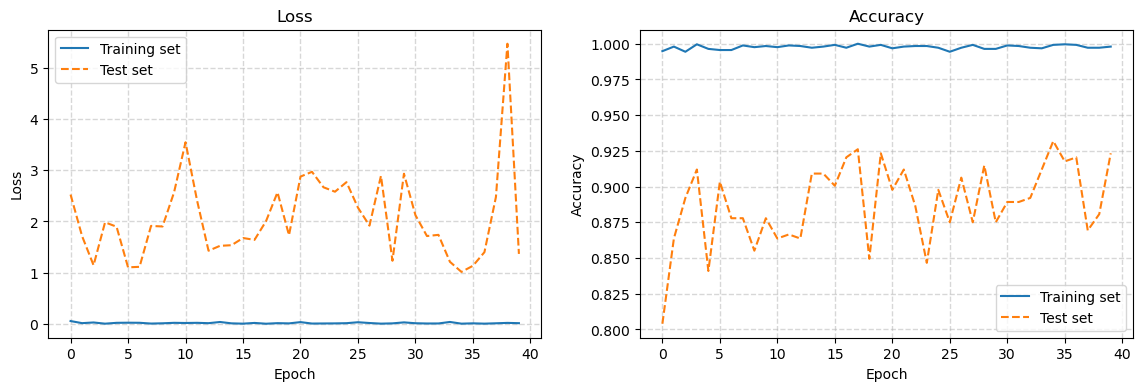

In [87]:
render_training_history(training_history)

In [93]:
import plotly.express as px
import matplotlib.pyplot as plt


# Assuming you have the accuracy values stored in lists or arrays
accuracy = training_history.history['accuracy']
val_accuracy = training_history.history['val_accuracy']

# Assuming epoch values range from 0 to 39 (40 values)
epoch = list(range(40))

# Create the scatter plot
fig = px.scatter()

# Add the training accuracy trace
fig.add_scatter(x=epoch, y=accuracy, name='Training set')

# Add the validation accuracy trace
fig.add_scatter(x=epoch, y=val_accuracy, name='Validation set')

fig.update_layout(
    title='Accuracy vs Epoch',
    xaxis_title='Epoch',
    yaxis_title='Accuracy',
    yaxis_range=[0, 1.0]  # Set the range of the y-axis for accuracy
)

fig.show()


In [94]:
import plotly.express as px

# Assuming you have the loss values stored in lists or arrays
loss = training_history.history['loss']
val_loss = training_history.history['val_loss']

# Assuming epoch values range from 0 to 39 (40 values)
epoch = list(range(40))

# Create the scatter plot
fig = px.scatter()

# Add the training loss trace
fig.add_scatter(x=epoch, y=loss, name='Training Loss')

# Add the validation loss trace
fig.add_scatter(x=epoch, y=val_loss, name='Validation Loss')

fig.update_layout(
    title='Loss vs Epoch',
    xaxis_title='Epoch',
    yaxis_title='Loss',
    yaxis=dict(range=[0, 4])  # Set the range of the y-axis for loss
)

fig.show()


In [95]:
# save cnn model
model_name = 'rock_paper_scissors_cnn_updated.h5'
model.save(model_name, save_format='h5')

In [91]:
! pip install plotly

In [2]:
import matplotlib.pyplot as plt
plt.switch_backend('tkagg')